<a href="https://colab.research.google.com/github/splitneutron/pca_assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.


What do you notice about the frequency of occurrence of different tokens? How does it look?

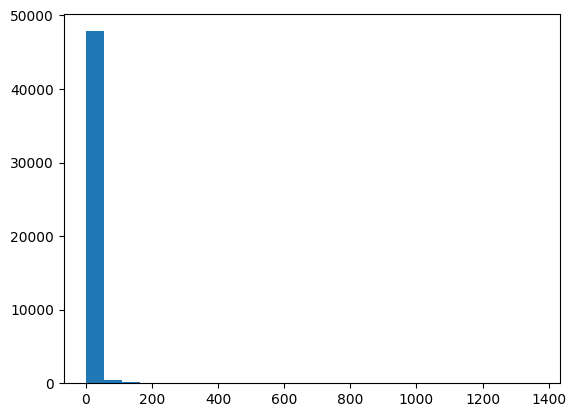

In [6]:
import matplotlib.pyplot as plt

# Extract token frequencies
frequencies = [freq for token, freq in token_freq]

# Plot histogram
plt.hist(frequencies, bins=25)
plt.show()

# Most of them occur under 200, the data is skewed right.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [1]:
import pandas as pd
import numpy as np

df = pd.read_parquet('Phishing_clean.parquet')

def maxmin(z):
    w = (z-np.min(z))/(np.max(z)-np.min(z))
    return w

y = df['Email Type'] # Create target variable vector
X = df.loc[:,'new':'italian'] # Create feature matrix

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

from sklearn.linear_model import LinearRegression # Import linear regression model
reg = LinearRegression(fit_intercept=False).fit(X_test, y_test) # Fit the linear model
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_}) # Regression coefficients
print('R-squared: ', reg.score(X_test, y_test)) # R squared measure

results.sort_values(by='coefficient', ascending=False)

# Largest are "koi" "miracle" and "cleburne"

R-squared:  0.8690627374187228


,variable,coefficient
1289,koi,2.640307
2588,miracle,2.612026
640,teco,2.178094
2268,ravages,1.914535
2110,interactive,1.765184
...,...,...
1949,nesa,-1.641827
1532,"me,",-1.672406
2542,therapy,-2.138866
632,tap,-2.300715


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

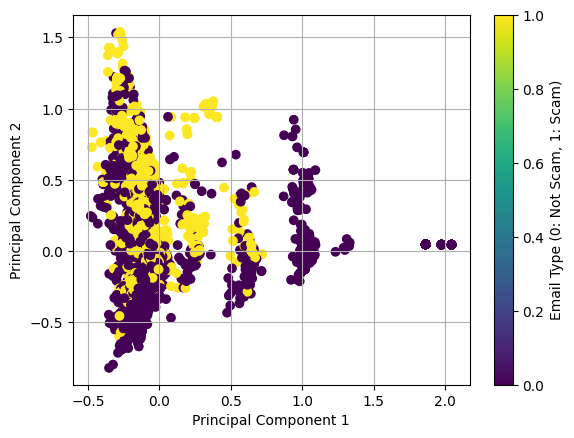

In [8]:
from sklearn.decomposition import PCA # Import PCA class
pca = PCA(n_components = 2) # Create PCA instance
pca = pca.fit(X) # Create the decomposition
X_pca = pca.transform(X)

import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Email Type (0: Not Scam, 1: Scam)')
plt.grid(True)
plt.show()

# For the highest Principal component 1 values, it is not a scam, but lower PC 1 values and higher PC 2 values are scams.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [2]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

y = df['Email Type'] # Create target variable vector
X = df.loc[:,'new':'italian'] # Create feature matrix

# Perform PCA on the training data
pca2 = PCA(n_components=2610)
pca2 = pca2.fit(X) # Create the decomposition
X_pca2610 = pca2.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca2610,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

from sklearn.linear_model import LinearRegression # Import linear regression model
reg = LinearRegression(fit_intercept=False).fit(X_test, y_test) # Fit the linear model
print('R-squared: ', reg.score(X_test, y_test)) # R squared measure

# better r-squared

R-squared:  0.8988345656999679


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

**Answer**

PCA is valuable in its ability to reduce the dimensions of a complex set of variables, where I can decorrelate the values and scale them however I'd like. With such a large dataset, we can disentangle the data better with PCA than if we just ran using the original data.

In [3]:
# End